## Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pycountry_convert as pc
import re
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import BayesSearchCV

pd.set_option('display.max_columns', 500)

## Load data

In [2]:
train = pd.read_csv("./data/train_data.csv")
test = pd.read_csv("./data/test_data.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")

# 1. Data preparation

In this section we filter the training dataset and prepare a sample to ease calculations (fast processing time):


In [3]:
train = train[train['has_won'] == 1] # The goal is to predict what bid price would have won us the auction

In [4]:
train_sample = train.sample(n=50000, random_state=42)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 812478 entries, 4519 to 7317062
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   eventTimestamp            812478 non-null  int64  
 1   unitDisplayType           812478 non-null  object 
 2   brandName                 812478 non-null  object 
 3   bundleId                  812478 non-null  object 
 4   appVersion                812478 non-null  object 
 5   correctModelName          812478 non-null  object 
 6   countryCode               812475 non-null  object 
 7   deviceId                  812478 non-null  object 
 8   osAndVersion              812478 non-null  object 
 9   connectionType            811812 non-null  object 
 10  c1                        812478 non-null  object 
 11  c2                        812478 non-null  float64
 12  c3                        812478 non-null  object 
 13  c4                        812478 non-nul

In [6]:
train.head()

,eventTimestamp,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,c1,c2,c3,c4,size,mediationProviderVersion,bidFloorPrice,sentPrice,winBid,has_won
4519,1656814988454,banner,Motorola,com.loop.match3d,1245.34.0,moto g(8) plus,MX,6a248921624,Android-10.0,WIFI,7d3,4.0,6b,3.0,320x50,11.4.2,0.01,0.03,0.03,1
4520,1656353017448,banner,Samsung,com.loop.match3d,1245.34.0,SM-A315F,IN,6a52684ae58,Android-11.0,WIFI,7d3,6.0,6b,7.0,320x50,11.4.2,0.01,0.03,0.03,1
4521,1657699159186,banner,Samsung,com.tilegarden.match3,1.8.55,SM-T220,TW,74b9cbb7db5,Android-11.0,WIFI,cb2,6.0,6b,8.0,728x90,11.4.3,0.05,0.05,0.05,1
4522,1657256957735,banner,Generic,com.loop.match3d,1245.35.0,Android 4.0,US,740f8afaadc,Android-4.0,WIFI,7d3,6.0,6b,6.0,320x50,11.4.3,0.01,0.38,0.38,1
4523,1657112273946,banner,Generic,com.loop.match3d,1245.34.0,Android 4.0,AU,74dff43bf3e,Android-4.0,WIFI,7d3,2.0,6b,2.0,320x50,11.4.2,0.01,0.18,0.18,1


In [7]:
train.describe()

,eventTimestamp,c2,c4,bidFloorPrice,sentPrice,winBid,has_won
count,8.124780e+05,812478.000000,812478.000000,812478.000000,812478.000000,812478.000000,812478.0
mean,1.657035e+12,5.001531,4.995169,0.015098,0.342622,0.342622,1.0
std,4.076824e+08,2.344538,2.344014,0.055927,4.092761,4.092761,0.0
min,1.656290e+12,1.000000,1.000000,0.010000,0.010000,0.010000,1.0
25%,1.656684e+12,3.000000,3.000000,0.010000,0.020000,0.020000,1.0
50%,1.657011e+12,5.000000,5.000000,0.010000,0.030000,0.030000,1.0
75%,1.657395e+12,7.000000,7.000000,0.010000,0.100000,0.100000,1.0
max,1.657759e+12,9.000000,9.000000,5.000000,425.000000,425.000000,1.0


In [8]:
def data_preparation(df):
    summary = df['brandName'].value_counts().sort_values(ascending=False)
    categories_to_keep = (df['brandName'].value_counts().sort_values(ascending=False)[0:30]/len(df)).reset_index()[:7]['index']
    df.loc[~df['brandName'].isin(categories_to_keep), 'brandName'] = 'Other_brand'
        
    return df

In [9]:
train_sample = data_preparation(train_sample)
train = data_preparation(train)
test = data_preparation(test)

# 2. Data engineering

The provided code is a collection of functions that perform various data engineering tasks on a DataFrame. The code aims to transform and manipulate the data to prepare it for further analysis or modeling. In general, it extracts new information from existing columns, create new columns based on time dimension, create new columns based on aggregated statistics, handling of missing values, encoding categorical variables, and general data cleaning and transformation.

In [10]:
def extract_app_category(bundle_id):
    # Extracts the app category from the bundle ID.
    match = re.search(r'com\.(.*?)\.', bundle_id)
    return match.group(1) if match else None

def extract_major_version(app_version):
    # Extracts the major version number from the app version.
    match = re.search(r'^(\d+)\.', app_version)
    return int(match.group(1)) if match else None

def extract_minor_version(app_version):
    # Extracts the minor version number from the app version.
    match = re.search(r'\.(\d+)\.', app_version)
    return int(match.group(1)) if match else None

def get_continent(country):
    try:
        # Converts the country code to the corresponding continent code using pycountry_convert library.
        continent = pc.country_alpha2_to_continent_code(country)
        return continent
    except:
        # If an error occurs or the country code is invalid, return NaN.
        return np.nan

def check_os_type(string):
    if 'iOS' in string:
        # Extracts the iOS version number from the string.
        version = int(string.split('-')[1])
        if version <= 12: # Checking if the iOS version is less than or equal to 12.
            return 'old_device' # Reference: https://www.lifewire.com/android-versions-4173277
        elif (version > 12) & (version < 16): # Checking if the iOS version is greater than 12 and less than 16.
            return 'new_device'
        elif version >= 16: # Checking if the iOS version is greater than or equal to 16.
            return 'latest_device'
    elif 'Android' in string:
        # Extracts the Android version number from the string.
        version = int(string.split('-')[1])
        if version < 7: # Checking if the Android version is less than 7.
            return 'old_device' # Reference: https://www.lifewire.com/android-versions-4173277
        elif (version >= 7) & (version < 11): # Checking if the Android version is between 7 and 11 (exclusive).
            return 'new_device'
        elif version >= 11: # Checking if the Android version is greater than or equal to 11.
            return 'latest_device'


def create_new_columns(df):
    # Create new time-related features using the eventTimestamp column. Reference: https://stackoverflow.com/questions/30071886/how-to-get-current-time-in-python-and-break-up-into-year-month-day-hour-minu
    df['eventTimestamp'] = pd.to_datetime(df['eventTimestamp'], unit='ms')

    # Extract month, day, hour, minute, and second from the eventTimestamp.
    df['month'] = df['eventTimestamp'].dt.month
    df['day'] = df['eventTimestamp'].dt.day
    df['hour'] = df['eventTimestamp'].dt.hour
    df['minute'] = df['eventTimestamp'].dt.minute
    df['second'] = df['eventTimestamp'].dt.second

    # Determine if the event falls on a weekend (0 = weekday, 1 = weekend).
    df['is_weekend'] = df['eventTimestamp'].dt.dayofweek // 5

    # Categorize the time of day based on the hour of the event.
    df['time_of_day'] = pd.cut(df['hour'], bins=[-1, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'])

    return df

def identify_popular_brands(df):
    # Identify the top 8 popular brands based on the brandName column.
    popular_brands = df['brandName'].value_counts().sort_values(ascending=False).index[:8]

    # Create a new column 'is_popular_brand' indicating whether the brand is popular or not.
    df['is_popular_brand'] = df['brandName'].apply(lambda x: 1 if x in popular_brands else 0)

    return df

def extract_app_and_version(df):
    # Extract the app category from the bundleId column using the extract_app_category function.
    df['appCategory'] = df['bundleId'].apply(extract_app_category)

    # Remove the bundleId column.
    df = df.drop(columns='bundleId')

    # Extract the major and minor versions from the appVersion column using the extract_major_version and extract_minor_version functions.
    df['majorVersion'] = df['appVersion'].apply(extract_major_version)
    df['minorVersion'] = df['appVersion'].apply(extract_minor_version)

    # Remove the appVersion column.
    df = df.drop(columns='appVersion')

    return df

def aggregate_bid_price_statistics(df):
    # Aggregate bidFloorPrice and sentPrice statistics per deviceId.
    aggregated_df = df.groupby(['deviceId'])[['bidFloorPrice', 'sentPrice']].agg(['mean', 'median', 'std', 'max', 'min', 'sum', 'count']).reset_index()

    # Rename the aggregated columns with appropriate names.
    aggregated_df.columns = [col[0] + col[1].capitalize() for col in aggregated_df.columns]

    # Merge the aggregated statistics back to the original dataframe based on deviceId.
    df = df.merge(aggregated_df, on=['deviceId'], how='left')

    return df

def aggregate_price_statistics_per_time_intervals(df):
    # Aggregate bidFloorPrice and sentPrice statistics per day.
    aggregated_df = df.groupby(df['eventTimestamp'].dt.date)[['bidFloorPrice', 'sentPrice']].agg(['mean', 'median', 'std', 'max', 'min', 'sum', 'count']).reset_index()

    # Rename the aggregated columns with appropriate names, adding 'DailyAvgPrices' as a prefix.
    aggregated_df.columns = [(col[0] + 'DailyAvgPrices' + col[1].capitalize()) if index != 0 else col[0] for index, col in enumerate(aggregated_df.columns)]

    # Add a new 'date' column to the original dataframe to match with the aggregated statistics.
    df['date'] = df['eventTimestamp'].dt.date

    # Merge the aggregated statistics back to the original dataframe based on date.
    df = df.merge(aggregated_df, left_on='date', right_on='eventTimestamp', how='left')

    # Drop unnecessary columns and rename the eventTimestamp columns.
    df = df.drop(columns=['date', 'eventTimestamp_y'])
    df = df.rename(columns={'eventTimestamp_x': 'eventTimestamp'})

    # Aggregate bidFloorPrice and sentPrice statistics per hour.
    aggregated_df = df.groupby(df['eventTimestamp'].dt.strftime('%Y-%m-%d %H'))[['bidFloorPrice', 'sentPrice']].agg(['mean', 'median', 'std', 'max', 'min', 'sum', 'count']).reset_index()

    # Rename the aggregated columns with appropriate names, adding 'HourlyPrices' as a prefix.
    aggregated_df.columns = [(col[0] + 'HourlyPrices' + col[1].capitalize()) if index != 0 else col[0] for index, col in enumerate(aggregated_df.columns)]

    # Add a new 'date_hourly' column to the original dataframe to match with the aggregated statistics.
    df['date_hourly'] = df['eventTimestamp'].dt.strftime('%Y-%m-%d %H')

    # Merge the aggregated statistics back to the original dataframe based on date_hourly.
    df = df.merge(aggregated_df, left_on='date_hourly', right_on='eventTimestamp', how='left')

    # Drop unnecessary columns and rename the eventTimestamp columns.
    df = df.drop(columns=['date_hourly', 'eventTimestamp_y'])
    df = df.rename(columns={'eventTimestamp_x': 'eventTimestamp'})

    # Aggregate bidFloorPrice and sentPrice statistics per minute.
    aggregated_df = df.groupby(df['eventTimestamp'].dt.strftime('%Y-%m-%d %H:%M'))[['bidFloorPrice', 'sentPrice']].agg(['mean', 'median', 'std', 'max', 'min', 'sum', 'count']).reset_index()

    # Rename the aggregated columns with appropriate names, adding 'MinutePrices' as a prefix.
    aggregated_df.columns = [(col[0] + 'MinutePrices' + col[1].capitalize()) if index != 0 else col[0] for index, col in enumerate(aggregated_df.columns)]

    # Add a new 'date_minute' column to the original dataframe to match with the aggregated statistics.
    df['date_minute'] = df['eventTimestamp'].dt.strftime('%Y-%m-%d %H:%M')

    # Merge the aggregated statistics back to the original dataframe based on date_minute.
    df = df.merge(aggregated_df, left_on='date_minute', right_on='eventTimestamp', how='left')

    # Drop unnecessary columns and rename the eventTimestamp columns.
    df = df.drop(columns=['date_minute', 'eventTimestamp_y'])
    df = df.rename(columns={'eventTimestamp_x': 'eventTimestamp'})

    return df


def aggregate_unit_display_type_counts(df):
    # Aggregate unitDisplayType counts per day, hour, and minute.
    daily_ad_request_count = df.groupby(df['eventTimestamp'].dt.date)['unitDisplayType'].count()
    daily_ad_request_count.name = 'unitDisplayTypeDailyCount'

    hourly_ad_request_count = df.groupby(df['eventTimestamp'].dt.strftime('%Y-%m-%d %H'))['unitDisplayType'].count()
    hourly_ad_request_count.name = 'unitDisplayTypeHourlyCount'

    minute_ad_request_count = df.groupby(df['eventTimestamp'].dt.strftime('%Y-%m-%d %H:%M'))['unitDisplayType'].count()
    minute_ad_request_count.name = 'unitDisplayTypeMinuteCount'

    # Merge the aggregated counts back to the original dataframe based on the corresponding timestamps.
    df = df.merge(daily_ad_request_count, left_on=df['eventTimestamp'].dt.date, right_index=True, how='left')
    df = df.merge(hourly_ad_request_count, left_on=df['eventTimestamp'].dt.strftime('%Y-%m-%d %H'), right_index=True, how='left')
    df = df.merge(minute_ad_request_count, left_on=df['eventTimestamp'].dt.strftime('%Y-%m-%d %H:%M'), right_index=True, how='left')
    
    return df

def extract_os_and_version(df):
    # Extract the OS and version from the osAndVersion column.
    df['os'] = df['osAndVersion'].str.split(".", expand=True)[0]
    df['version'] = df['osAndVersion'].str.split(".", expand=True)[1].fillna(0).astype(int)

    # Remove the osAndVersion column.
    df = df.drop(columns='osAndVersion')
    
    return df

def add_continent_column(df):
    # Function to get the continent based on the country code.
    def get_continent(country):
        try:
            continent = pc.country_alpha2_to_continent_code(country)
            return continent
        except:
            return 'UNKNOWN'

    # Apply the get_continent function to create a new 'continent' column.
    df['continent'] = df['countryCode'].apply(get_continent)
    
    return df

def extract_device_width_and_height(df):
    # Extract device width and height from the 'size' column.
    df['device_width'] = df['size'].str.split("x", expand=True)[0].fillna(0).astype(int)
    df['device_height'] = df['size'].str.split("x", expand=True)[1].fillna(0).astype(int)

    # Remove the 'size' column.
    df = df.drop(columns='size')
    
    return df

def modify_mediation_provider_version(df):
    # Split the mediationProviderVersion into three parts and convert them to integers.
    df['mediationProviderVersion_a'] = df['mediationProviderVersion'].str.split(".", expand=True)[0].fillna(0).astype(int)
    df['mediationProviderVersion_b'] = df['mediationProviderVersion'].str.split(".", expand=True)[0].fillna(0).astype(int)
    df['mediationProviderVersion_c'] = df['mediationProviderVersion'].str.split(".", expand=True)[0].fillna(0).astype(int)

    # Remove the 'mediationProviderVersion' column.
    df = df.drop(columns='mediationProviderVersion')
    
    return df

def modify_os(df):
    # Apply the check_os_type function to modify the 'os' column.
    df['os'] = df['os'].apply(check_os_type)

    # Remove the 'os' column.
    df = df.drop(columns='os')
    
    return df

def fill_missing_values(df):
    # Fill missing values in specific columns with default values.
    df['connectionType'] = df['connectionType'].fillna('UNKNOWN')
    df['appCategory'] = df['appCategory'].fillna('UNKNOWN')
    df['minorVersion'] = df['minorVersion'].fillna(df['minorVersion'].median())
    
    # Drop rows with missing values in the 'continent' column.
    df = df.dropna(subset=['continent'])
    
    # Drop unnecessary columns.
    df = df.drop(columns=['correctModelName', 'countryCode', 'c1', 'brandName']) 
    
    return df

def one_hot_encoding(df):
    # Define categorical variables for one-hot encoding.
    categorical_variables = ['unitDisplayType', 'connectionType', 'c3', 'time_of_day', 'appCategory', 'majorVersion', 'continent']

    # Perform one-hot encoding for categorical variables.
    df = pd.get_dummies(df, columns=categorical_variables, dtype=int)
    
    # Set 'eventTimestamp' as the index.
    df = df.set_index(['eventTimestamp', 'deviceId'])
    
    return df

def missing_val_imputer(df):
    # Fill missing values in each column with its median.
    for col in df.columns:
        if df[col].isna().any():
            median_value = df[col].median()
            df[col] = df[col].fillna(median_value)
    
    return df


def data_engineering(df):
    df = create_new_columns(df)
    df = identify_popular_brands(df)
    df = extract_app_and_version(df)
    df = aggregate_bid_price_statistics(df)
    df = aggregate_price_statistics_per_time_intervals(df)
    df = aggregate_unit_display_type_counts(df)
    df = extract_os_and_version(df)
    df = add_continent_column(df)
    df = extract_device_width_and_height(df)
    df = modify_mediation_provider_version(df)
    df = modify_os(df)
    df = fill_missing_values(df)
    df = one_hot_encoding(df)
    
    return df


In [11]:
processed_data_train_sample = data_engineering(train_sample)
processed_data_train = data_engineering(train)
processed_data_test = data_engineering(test)

In [12]:
processed_data_test.shape

(41586, 112)

In [13]:
# Separate the features (X) and the target variable (y)
X = processed_data_train_sample.drop(['winBid', 'has_won'], axis=1) # to avoid data leakeage I remove the 'has_won' column
y = processed_data_train_sample['winBid']

#### Impute missing values

In [14]:
X = missing_val_imputer(X)
X.isna().sum().sort_values(ascending=False)

c2                                  0
unitDisplayTypeMinuteCount          0
connectionType_UNKNOWN              0
connectionType_3G                   0
unitDisplayType_rewarded            0
                                   ..
sentPriceDailyAvgPricesMean         0
bidFloorPriceDailyAvgPricesCount    0
bidFloorPriceDailyAvgPricesSum      0
bidFloorPriceDailyAvgPricesMin      0
continent_SA                        0
Length: 111, dtype: int64

#### Variable Selection

In [15]:
# reference: https://mljar.com/blog/feature-importance-in-random-forest/
model = RandomForestRegressor()
model.fit(X, y)

importances = model.feature_importances_

importance_cutoff = np.median(importances)

selected_features = X.columns[importances > importance_cutoff]

indices = np.argsort(importances)[::-1]

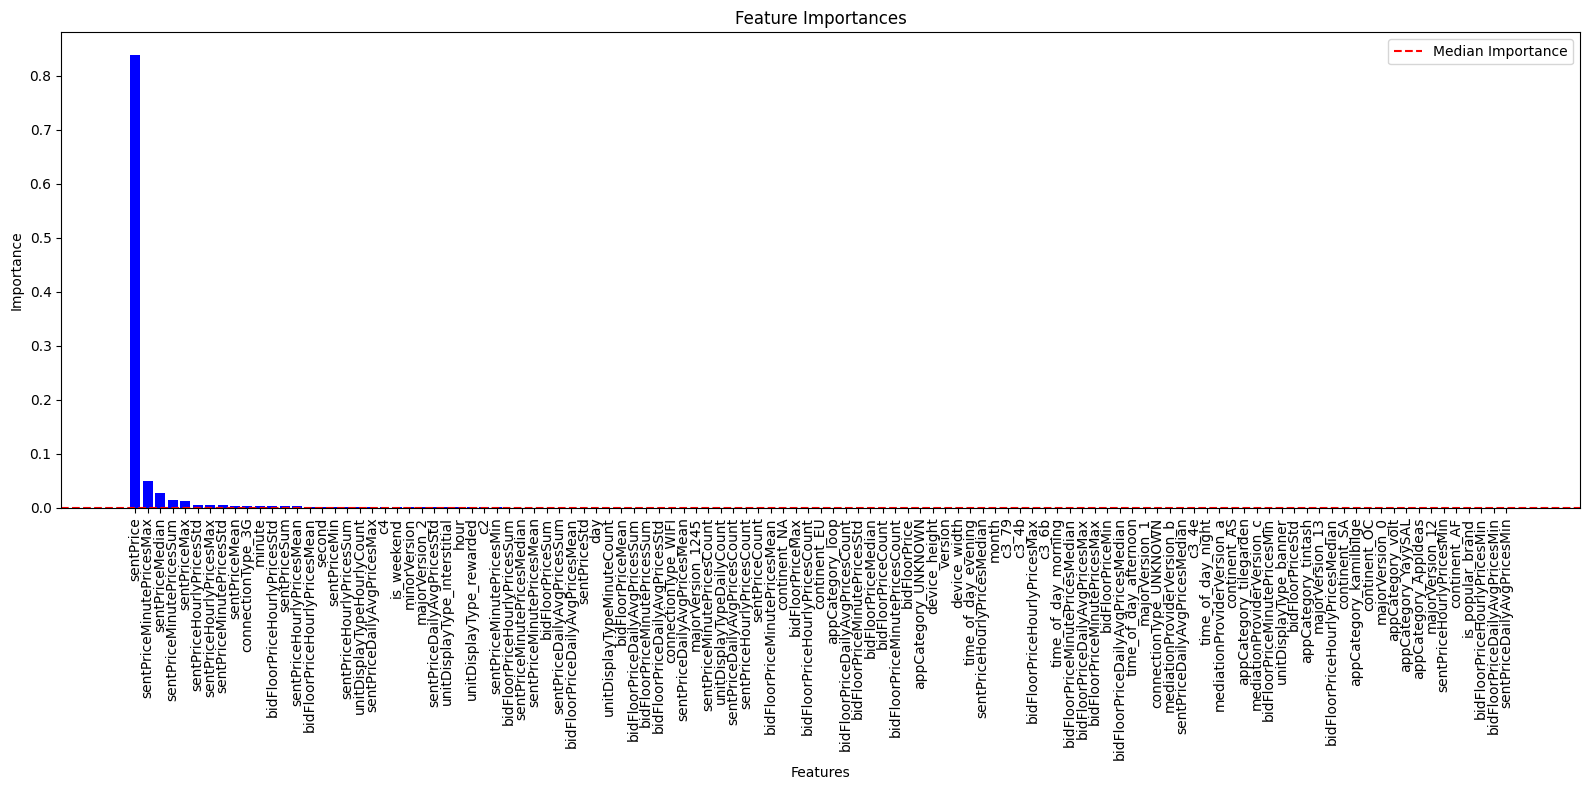

In [16]:
# Plot the feature importances with a vertically oriented graph
plt.figure(figsize=(16, 8))  # Adjust the figsize parameter as per your preference
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color='b', align='center')
plt.axhline(y=importance_cutoff, color='red', linestyle='--', label='Median Importance')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
X = X[selected_features]

In [18]:
selected_features

# ['c2', 'c4', 'sentPrice', 'day', 'hour', 'minute', 'second',
#        'is_weekend', 'minorVersion', 'bidFloorPriceMean', 'bidFloorPriceMax',
#        'bidFloorPriceSum', 'sentPriceMean', 'sentPriceMedian', 'sentPriceStd',
#        'sentPriceMax', 'sentPriceMin', 'sentPriceSum', 'sentPriceCount',
#        'bidFloorPriceDailyAvgPricesMean', 'bidFloorPriceDailyAvgPricesStd',
#        'bidFloorPriceDailyAvgPricesSum', 'sentPriceDailyAvgPricesMean',
#        'sentPriceDailyAvgPricesStd', 'sentPriceDailyAvgPricesMax',
#        'sentPriceDailyAvgPricesSum', 'sentPriceDailyAvgPricesCount',
#        'bidFloorPriceHourlyPricesMean', 'bidFloorPriceHourlyPricesStd',
#        'bidFloorPriceHourlyPricesSum', 'bidFloorPriceHourlyPricesCount',
#        'sentPriceHourlyPricesMean', 'sentPriceHourlyPricesStd',
#        'sentPriceHourlyPricesMax', 'sentPriceHourlyPricesSum',
#        'sentPriceHourlyPricesCount', 'bidFloorPriceMinutePricesMean',
#        'bidFloorPriceMinutePricesSum', 'sentPriceMinutePricesMean',
#        'sentPriceMinutePricesMedian', 'sentPriceMinutePricesStd',
#        'sentPriceMinutePricesMax', 'sentPriceMinutePricesMin',
#        'sentPriceMinutePricesSum', 'sentPriceMinutePricesCount',
#        'unitDisplayTypeDailyCount', 'unitDisplayTypeHourlyCount',
#        'unitDisplayTypeMinuteCount', 'unitDisplayType_interstitial',
#        'unitDisplayType_rewarded', 'connectionType_3G', 'connectionType_WIFI',
#        'majorVersion_2', 'majorVersion_1245', 'continent_NA']

Index(['c2', 'c4', 'sentPrice', 'day', 'hour', 'minute', 'second',
       'is_weekend', 'minorVersion', 'bidFloorPriceMean', 'bidFloorPriceMax',
       'bidFloorPriceSum', 'sentPriceMean', 'sentPriceMedian', 'sentPriceStd',
       'sentPriceMax', 'sentPriceMin', 'sentPriceSum', 'sentPriceCount',
       'bidFloorPriceDailyAvgPricesMean', 'bidFloorPriceDailyAvgPricesStd',
       'bidFloorPriceDailyAvgPricesSum', 'sentPriceDailyAvgPricesMean',
       'sentPriceDailyAvgPricesStd', 'sentPriceDailyAvgPricesMax',
       'sentPriceDailyAvgPricesSum', 'sentPriceDailyAvgPricesCount',
       'bidFloorPriceHourlyPricesMean', 'bidFloorPriceHourlyPricesStd',
       'bidFloorPriceHourlyPricesSum', 'bidFloorPriceHourlyPricesCount',
       'sentPriceHourlyPricesMean', 'sentPriceHourlyPricesStd',
       'sentPriceHourlyPricesMax', 'sentPriceHourlyPricesSum',
       'sentPriceHourlyPricesCount', 'bidFloorPriceMinutePricesMean',
       'bidFloorPriceMinutePricesSum', 'sentPriceMinutePricesMean',
       's

# 3. Modeling + Evaluation

#### hyperparameter Tuning

In [20]:
param_grid = {
    'n_estimators': (200, 450),
    'max_depth': (5, 20),
    'min_samples_split': (0.01, 0.1),
    'min_samples_leaf': (0.01, 0.1),
}

model = RandomForestRegressor()

bayesian_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_grid,
    n_iter=5,
    cv=5,
    scoring='neg_mean_squared_error',  
    n_jobs=-1
)
bayesian_search.fit(X, y) 

BayesSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5, n_jobs=-1,
              scoring='neg_mean_squared_error',
              search_spaces={'max_depth': (5, 20),
                             'min_samples_leaf': (0.01, 0.1),
                             'min_samples_split': (0.01, 0.1),
                             'n_estimators': (200, 450)})

In [21]:
best_params = bayesian_search.best_params_
best_model = bayesian_search.best_estimator_

In [22]:
best_params

# OrderedDict([('max_depth', 15),
#              ('min_samples_leaf', 0.010785301076966096),
#              ('min_samples_split', 0.08456772280422782),
#              ('n_estimators', 340)])

OrderedDict([('max_depth', 10),
             ('min_samples_leaf', 0.032857475153737166),
             ('min_samples_split', 0.05268149859793972),
             ('n_estimators', 219)])

#### Train final model

In [23]:
# Separate the features (X) and the target variable (y)
X = processed_data_train.drop(['winBid', 'has_won'], axis=1) # to avoid data leakeage I remove the 'has_won' column
y = processed_data_train['winBid']

X = missing_val_imputer(X)

X = X[selected_features]

In [24]:
# Train the final model using the best parameters
final_model = RandomForestRegressor(**best_params, n_jobs = -3)
final_model.fit(X, y)

RandomForestRegressor(max_depth=10, min_samples_leaf=0.032857475153737166,
                      min_samples_split=0.05268149859793972, n_estimators=219,
                      n_jobs=-3)

In [25]:
file_path = 'RF_regressor.pickle'

with open(file_path, 'wb') as file:
    pickle.dump(final_model, file)

#### Predictions

In [26]:
# final_model = pickle.load(open('RF_regressor.pickle', 'rb'))

In [27]:
# Make predictions on the test set
X_test = missing_val_imputer(processed_data_test)
X_test = X_test[selected_features]
X_test['sentPriceStd'] = X_test['sentPriceStd'].fillna(0) # Test set has nans in the sentPriceStd because there was only 1 device (count) in the aggregation, therefore the SD = 0

c:\Users\FI40WR\Anaconda3\envs\random_walk\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\FI40WR\Anaconda3\envs\random_walk\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\FI40WR\AppData\Local\Temp\ipykernel_11908\2789047254.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['sentPriceStd'] = X_test['sentPriceStd'].fillna(0) # Test set has nans in the sentPriceStd because there was only 1 device (count) in the aggregation, therefore the SD = 0


In [28]:
y_pred_train = final_model.predict(X)
y_pred_test = final_model.predict(X_test)

#### Validation

In [29]:
mse = mean_squared_error(y, y_pred_train)
print("Mean Squared Error:", mse)

r2 = r2_score(y, y_pred_train)
print("R-squared:", r2)

mae = mean_absolute_error(y, y_pred_train)
print("Mean Absolute Error:", mae)

print("Root Mean Squred Error:", np.sqrt(mse))

Mean Squared Error: 15.519179386766007
R-squared: 0.07351911882318396
Mean Absolute Error: 0.27780022687374734
Root Mean Squred Error: 3.9394389685291493


# Submission

In [30]:
X_test['winBid'] = y_pred_test
X_test = X_test.reset_index()

C:\Users\FI40WR\AppData\Local\Temp\ipykernel_11908\210499547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['winBid'] = y_pred_test


In [31]:
sample_submission = sample_submission.merge(X_test[['deviceId','winBid']], on = 'deviceId', how='left') \
                    .drop(columns='winBid_x') \
                    .rename(columns={'winBid_y':'winBid'})

In [32]:
sample_submission

,deviceId,winBid
0,6a049646837,0.110108
1,6a0616b862a,0.195717
2,6a0769d0ad5,0.110108
3,6a0dc74cfeb,0.045061
4,6a0e80f23a7,0.020000
...,...,...
41581,80f44e90c2f,0.030000
41582,80f7e0d43af,0.020000
41583,80fc51ceb15,0.067946
41584,80fd5e7625d,0.030000


In [33]:
sample_submission.to_csv("./data/sample_submission_jose.csv")